# ISM / Confocal image processing for fluorescence lifetime reconstruction. DFD acquisition method

### Import libraries to process 4D ISM dataset (Nx, Ny, time bin, detector channel) of both acquired sample and IRF  

In [1]:
import h5py
import brighteyes_flim as flim
import matplotlib.pyplot as plt
import numpy as np
import brighteyes_ism.analysis.Graph_lib as gr
from scipy.ndimage import shift
from skimage.registration import phase_cross_correlation
import brighteyes_ism.dataio.mcs as mcs

### Load the ISM dataset and align the histograms along the channels' dimension

In [2]:
#load the data

with h5py.File(r"C:\Users\fdelbufalo\Desktop\images\data-10-04-2024-17-42-38.h5","r") as f:
    
        print(f.keys())
        data_input = f["data"]  # image with the decay histograms in each pixel realigned 
                                     # with respect to the signal which triggers the beginning of the excitation
        data = data_input[0, 0,...]

<KeysViewHDF5 ['configurationFPGA', 'configurationGUI', 'configurationGUI_beforeStart', 'configurationSpadFCSmanager', 'data', 'data_channels_extra']>


In [3]:
# load the IRF

data_path_irf = r"C:\Users\fdelbufalo\Desktop\images\data-10-04-2024-18-31-53.h5"
data_irf = h5py.File(data_path_irf)

image_irf = data_irf["data"]
data_hist_irf = np.sum(image_irf, axis=(0, 1, 2, 3))
print(data_hist_irf.shape)

(81, 25)


In [4]:
#load data laser (26th channel) for the convallaria and calculate the correspondent phasor

data_path = r"C:\Users\fdelbufalo\Desktop\images\data-10-04-2024-17-42-38.h5"
data_extra, _ = mcs.load(data_path, key="data_channels_extra")
data_laser = data_extra[:, :, :, :, :, 1]
print(data_laser.shape)
data_laser_hist = np.sum(data_laser, axis = (0,1,2,3))
phasor_laser = flim.calculate_phasor(data_laser_hist)
print(phasor_laser)

(1, 1, 2000, 2000, 81)
(-0.8007615062044597-0.5723499255555233j)


In [5]:
#load data laser (26th channel) for the IRF and calculate the correspondent phasor

data_extra_irf, _ = mcs.load(data_path_irf, key="data_channels_extra")
data_laser_irf = data_extra_irf[:, :, :, :, :, 1]
print(data_laser_irf.shape)
data_laser_hist_irf = np.sum(data_laser_irf, axis = (0,1,2,3))
phasor_laser_irf = flim.calculate_phasor(data_laser_hist_irf)
print(phasor_laser_irf)

(1, 1, 500, 500, 81)
(-0.9724567964359583+0.15208946764244183j)


nchannels 25
irf_shifted (81, 25)


C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_13192\3908103851.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:, 12], data_hist_irf[:, i], upsample_factor=10, normalization=None)


shift_dset (3, 25)
dset_shifted (2000, 2000, 81, 25)


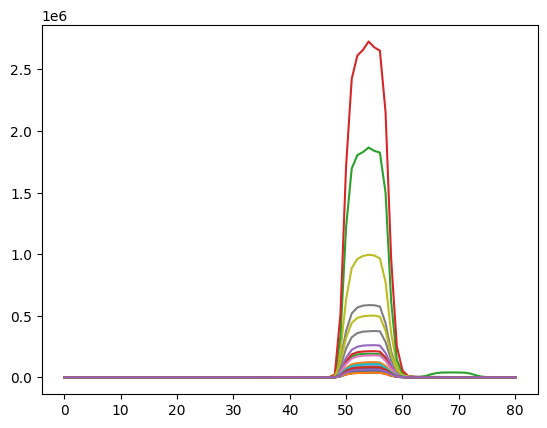

In [7]:
nch = data_hist_irf.shape[-1]
print("nchannels", nch)

shift_vec = np.empty( nch )

for i in range(nch):
    shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:, 12], data_hist_irf[:, i], upsample_factor=10, normalization=None)


irf_shifted = np.empty_like(data_hist_irf)
for i in range(nch):
    irf_shifted[:, i] = shift(data_hist_irf[:, i], shift_vec[i], order = 1, mode='grid-wrap')
    
print("irf_shifted", irf_shifted.shape)
plt.figure()
plt.plot(irf_shifted)


dset_shifted = np.empty_like(data)
shift_dset = np.zeros( (data.ndim - 1, nch) )
shift_dset[-1] = shift_vec
print("shift_dset", shift_dset.shape)

for i in range(nch):
    dset_shifted[..., i] = shift(data[..., i], shift_dset[:, i], order = 1, mode='grid-wrap')
    
print("dset_shifted", dset_shifted.shape)

data_3D = dset_shifted.sum(-1) 

###  Save in a .h5 file the phasors computed from the pixels'decay histograms performing a FFT on the histograms' time bins and extracting the first harmonic

In [9]:
flim.phasor_h5(data_path = r"C:\Users\fdelbufalo\Desktop\images\data-10-04-2024-17-42-38.h5", data_input = data_3D) 

c:\users\fdelbufalo\pycharmprojects\brighteyes-flim\src\brighteyes_flim\flism.py:381: RuntimeWarning: invalid value encountered in divide
  out = transform / flux


<Closed HDF5 dataset>

### Pixels' phasors are displayed in the phasor plot. Fluorescene decay histograms are not aligned with the first time bin and have not been corrected for the IRF . 


<KeysViewHDF5 ['h5_dataset_phasor_pix']>
(2000, 2000)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

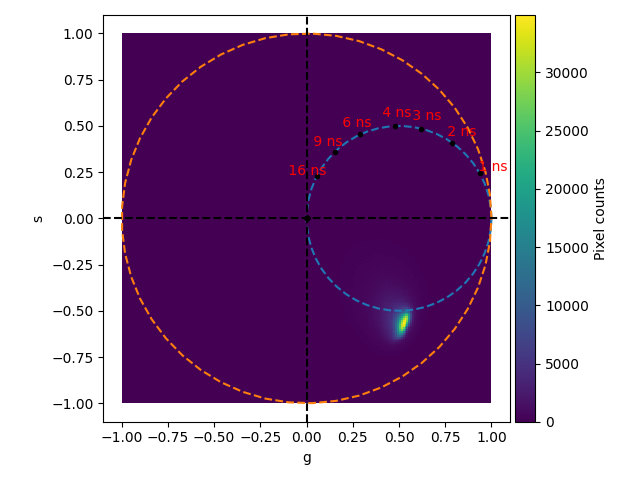

In [10]:
%matplotlib widget

hf_phasors_per_pixel = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\data-10-04-2024-17-42-38_phasors_matrix.h5", "r")
print(hf_phasors_per_pixel.keys())

phasors_pix = hf_phasors_per_pixel["h5_dataset_phasor_pix"]  # data with phasors in each pixel

print(phasors_pix.shape)

flim.plot_phasor(phasors_pix[:], bins_2dplot=200, log_scale=False, quadrant='all')

### Calculate phasor of the irf and the correction factor from the laser's (26th channel's) phasor to realign the phasors of the data in the phasor plot

In [18]:
irf_summed = np.sum(irf_shifted, axis = -1)
print(irf_summed.shape)
phasor_ir = flim.phasor(irf_summed)
print(phasor_ir)

(81,)
(-0.49265853623744255-0.8271757988606152j)


In [19]:
#  histograms
corr = flim.correction_phasor(data_laser_hist, data_laser_hist_irf)
print(corr)

(0.7139297345578988-0.7002173477671687j)


In [20]:
phasor_corrected = phasors_pix * corr / phasor_ir

### Display the phasor plot of the data realigned 

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

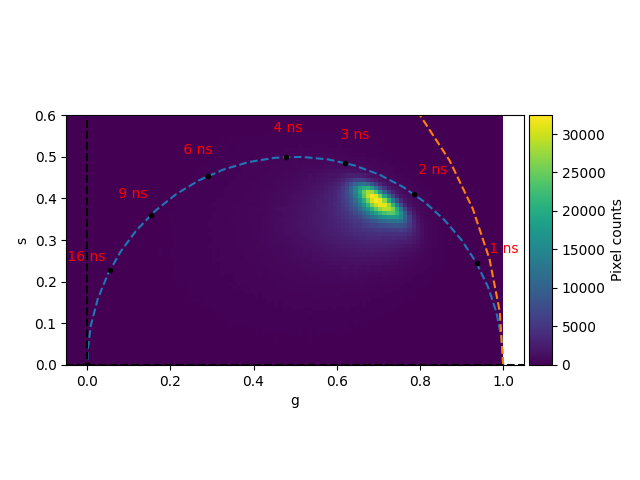

In [21]:
flim.plot_phasor(phasor_corrected, bins_2dplot=200, log_scale=False, quadrant='first')

# Lifetime analysis

#### Calculate the fluorescence lifetime from the phasor for each pixel with the formula below (f = dfd frequency or laser rep rate frequency):
#### τ<sub>φ</sub> = (1/(2*π*f)) * tan(φ)
#### φ = arctan(s/g)
#### g = Re{phasor_corrected}
#### s = Im{phasor_corrected}


In [22]:
tau_phi = flim.calculate_tau_phi(np.real(phasor_corrected), np.imag(phasor_corrected))
print(tau_phi.shape)



(2000, 2000)


#### Calculate the fluorescence lifetime from the phasor for each pixel with the formula below (f = dfd frequency or laser rep rate frequency):
#### τ<sub>m</sub> = (1/2*π*f) * √(1/m<sup>2</sup> - 1)
#### m = √g<sup>2</sup> + s<sup>2</sup>
#### g = Re{phasor_corrected}
#### s = Im{phasor_corrected}



In [23]:
tau_m = flim.calculate_tau_m(np.real(phasor_corrected), np.imag(phasor_corrected))
print(tau_m.shape)


(2000, 2000)


c:\users\fdelbufalo\pycharmprojects\brighteyes-flim\src\brighteyes_flim\flism.py:411: RuntimeWarning: invalid value encountered in sqrt
  tau_m = np.sqrt((1. / (m ** 2)) - 1) / (2 * np.pi * dfd_freq)


### Visualize histograms of tau distribution in the pixels and intensity map of the image 

(array([2.33000e+02, 2.49000e+02, 2.50000e+02, 2.83000e+02, 2.93000e+02,
        3.10000e+02, 3.07000e+02, 3.34000e+02, 3.80000e+02, 3.78000e+02,
        4.11000e+02, 4.29000e+02, 4.77000e+02, 5.24000e+02, 5.89000e+02,
        6.78000e+02, 8.26000e+02, 9.69000e+02, 1.17900e+03, 1.46100e+03,
        1.91500e+03, 2.32900e+03, 3.32500e+03, 4.51600e+03, 6.41400e+03,
        9.42100e+03, 1.42860e+04, 2.22920e+04, 3.81740e+04, 6.84200e+04,
        1.34076e+05, 2.82007e+05, 5.98855e+05, 9.11024e+05, 8.12095e+05,
        4.38813e+05, 1.77932e+05, 9.95600e+04, 6.70960e+04, 4.87570e+04,
        3.64990e+04, 2.81660e+04, 2.21750e+04, 1.77350e+04, 1.44490e+04,
        1.20930e+04, 1.01680e+04, 8.67500e+03, 7.16200e+03, 6.41600e+03]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92

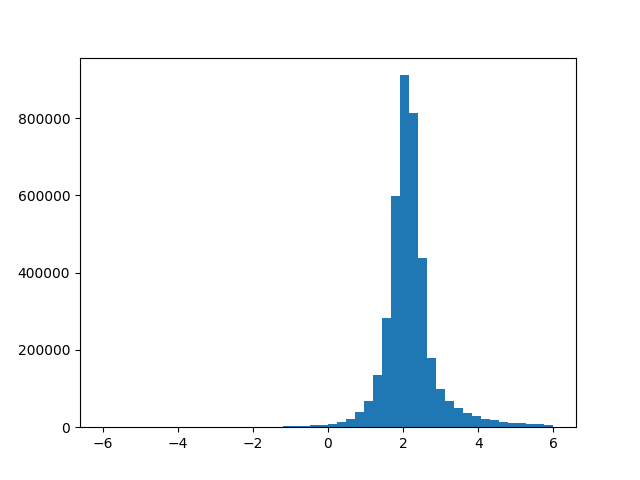

In [24]:
tau_data = 1e9*tau_phi.flatten()

plt.figure()
plt.hist(tau_data, range = (-6, 6), bins = 50)

(array([1.13000e+02, 3.92000e+02, 7.82000e+02, 1.54700e+03, 2.95900e+03,
        5.82700e+03, 1.18140e+04, 2.60120e+04, 7.76740e+04, 3.31791e+05,
        7.26677e+05, 7.76060e+05, 4.83649e+05, 2.88431e+05, 2.05793e+05,
        1.61295e+05, 1.30022e+05, 1.06966e+05, 8.77710e+04, 7.32280e+04,
        6.16770e+04, 5.14620e+04, 4.35300e+04, 3.71120e+04, 3.18560e+04,
        2.74140e+04, 2.41430e+04, 2.07260e+04, 1.82400e+04, 1.59390e+04,
        1.40910e+04, 1.24270e+04, 1.10840e+04, 9.88800e+03, 9.14300e+03,
        8.05200e+03, 7.29600e+03, 6.51400e+03, 5.96900e+03, 5.26300e+03,
        4.94800e+03, 4.37800e+03, 4.04500e+03, 3.73200e+03, 3.44000e+03,
        3.12400e+03, 2.86900e+03, 2.70900e+03, 2.50900e+03, 2.24200e+03]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58

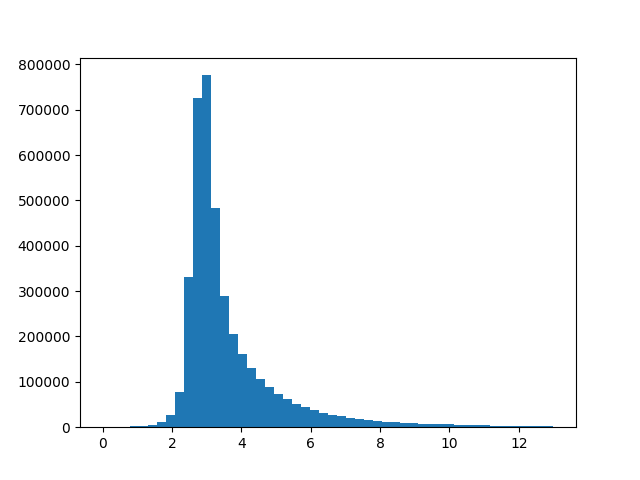

In [25]:
tau_m_data = 1e9*tau_m.flatten()

plt.figure()
plt.hist(tau_m_data, range = (0, 13), bins = 50)

(2000, 2000)


(array([  2414.,  59267., 192869., 232012., 199888., 171379., 153854.,
        137053., 120038., 103489.,  89587.,  77496.,  68480.,  60690.,
         54438.,  49227.,  44753.,  41335.,  37432.,  34552.,  31910.,
         29319.,  27349.,  25434.,  23394.,  21940.,  20247.,  19078.,
         17854.,  17034.,  15802.,  15185.,  14182.,  13577.,  12856.,
         12301.,  11613.,  11184.,  10810.,  10071.,   9850.,   9482.,
          9026.,   8823.,   8492.,   8226.,   8170.,   7675.,   7639.,
          7289.,   7062.,   7023.,   6663.,   6506.,   6381.,   6239.,
          6266.,   5947.,   5912.,   5822.,   5760.,   5528.,   5504.,
          5464.,   5257.,   5234.,   5389.,   5171.,   4998.,   5090.,
          4881.,   4918.,   4930.,   4775.,   4839.,   4775.,   4850.,
          5033.,   4904.,   4774.,   4885.,   4989.,   4956.,   4944.,
          4906.,   4951.,   5006.,   4986.,   5133.,   4984.,   5162.,
          5181.,   5127.,   5109.,   5130.,   5231.,   5241.,   5247.,
      

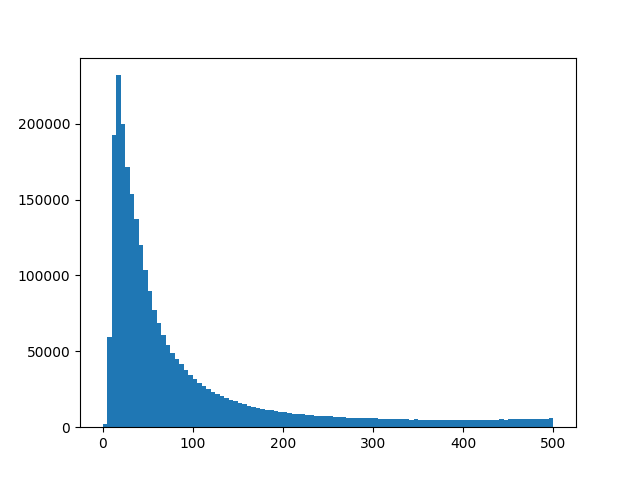

In [26]:
data_histograms = np.sum(data_3D, axis = -1)
print(data_histograms.shape)
    
# Plot the histogram of the photon counts in each pixel to see the distribution (e.g. check the level of noise) 
plt.figure()
plt.hist(data_histograms.flatten(), bins = 100, range = (0, 500))

### Display and save the FLIM image representing the lifetime and intensity with a 2D colormap

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:656: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


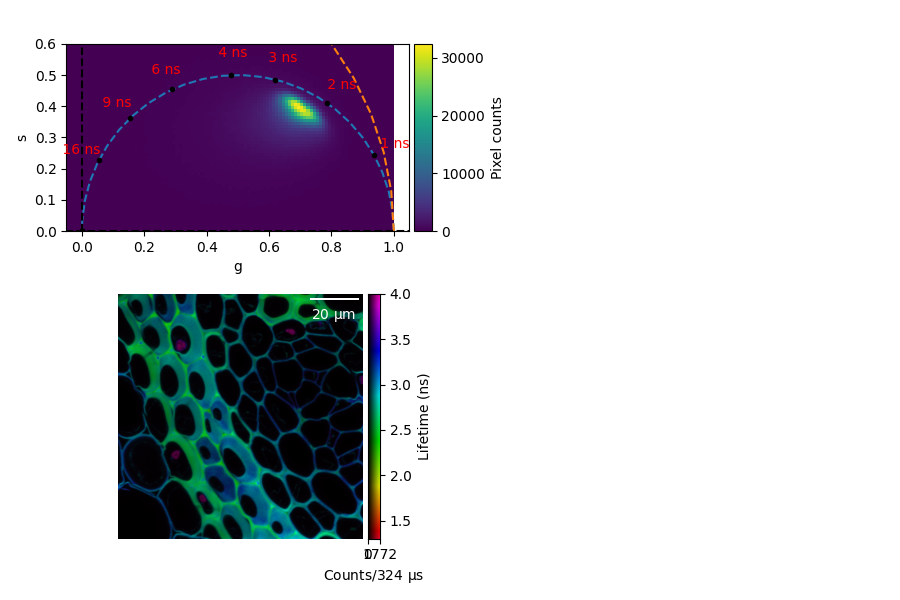

In [28]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
flim.plot_phasor(phasor_corrected[:], bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1)
gr.show_flim(data_histograms, tau_m*1e9, pxsize = 0.05, pxdwelltime = 324, lifetime_bounds = (1.3, 4), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\convallaria_C.pdf", dpi = 900)

### Plot the intensity images per channel

(2000, 2000, 25)


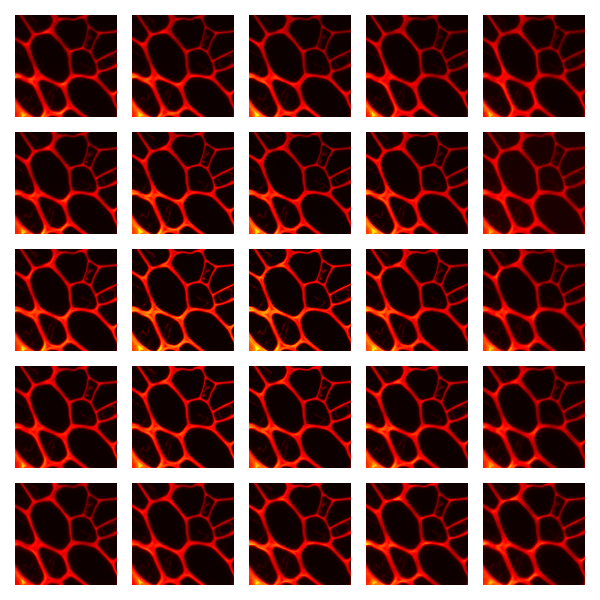

In [29]:
dataset = data.sum(axis = -2)
print(dataset.shape)
fig = gr.ShowDataset(dataset[1000:1750, 1200:1950])

### Plot intensity image (Nx x Ny)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

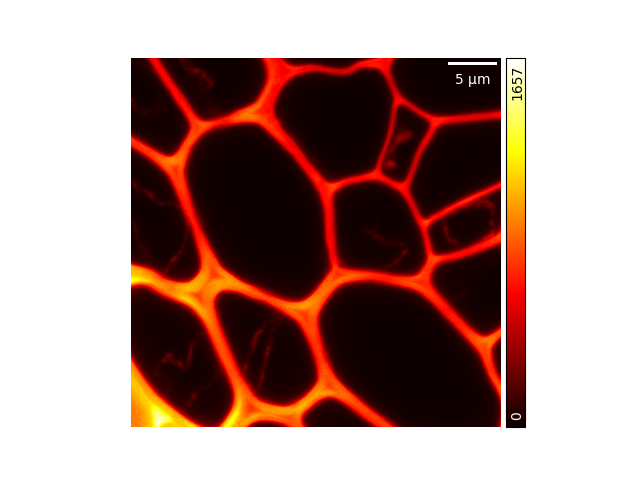

In [30]:
gr.ShowImg(data_histograms[1000:1750, 1200:1950], pxsize_x = 0.05)